***
### Modeling
____
A mobile phone company has a decided too many long term customers are still on legacy plans. Our goal is to analyze customer behavior of those utilizing the newer plans available, creating a recommendation model for the legacy customers.

Additional info:<br>
* We have been provided with cleaned data 
* The new plans are smart or ultra
* They need the model to be at least 75% accurate

Once we load the data, it will be split into training, validation, and test sets. Comparing a Logistic Regression model against a Random Forest Classifier model, both out-of-the-box and with hyperparameter tuning by fitting on training data, adjusting on validation data, and grading on the test set.

Data description<br>
Every observation in the dataset contains monthly behavior information about one user. The information given is as follows: <br>
сalls — number of calls<br>
minutes — total call duration in minutes<br>
messages — number of text messages<br>
mb_used — Internet traffic used in MB<br>
is_ultra — plan for the current month (Ultra - 1, Smart - 0)<br>

In [1]:
# libraries for data modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# load data
users = pd.read_csv('../users_behavior.csv')

In [3]:
# take a look at the contents
print(users.info())
print(users.describe())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000  

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


thoughts:<br>
We were told out data was cleaned, and it appears to be the case (nothing missing etc.)<br>
All data is numeric<br>
Other than the target feature (is_ultra), every feature's mean is slightly above their median value
'is_ultra' is a touch unbalanced: 30.6% ultra 69.4% smart

In [4]:
# filter data for training splits
features = users.drop(columns='is_ultra', axis=36)
target = users.iloc[:, -1]

In [5]:
# split into training and not training 3:2 ratio
feature_train, feature_t, target_train, target_t = train_test_split(
    features, target, test_size=0.4, random_state=36)

In [6]:
# split again into test / validation 1:1 ratio
feature_valid, feature_test, target_valid, target_test = train_test_split(
    feature_t, target_t, test_size=0.5, random_state=36)

In [7]:
# Logistic Regression out of the box
log_reg = LogisticRegression(random_state=36)
log_reg.fit(feature_train, target_train)
print(log_reg.score(feature_valid, target_valid))

0.7511664074650077


thoughts
___
75% is a great place to start.
Now let's tune it. Logistic Regression has plenty of parameters. Focus will be on penalty, how the model adjusts importance of features, and C parameter which controls the strength of the penalty, smaller the C value, the stronger those penalties are carried out. 

Out of the box uses lfgs as the solver and l2 for penalty. To check solver='liblinear' so we can examine compare lasso and ridge methods for penalty.

In [9]:
# Logistic Regression tuned

# params
regulation = ['l2', 'l1']
c = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

best_model = None
best_result = 0

for reg in regulation:
    for cc in c:
        log_reg = LogisticRegression(penalty=reg,
                                     C=cc,
                                     solver='liblinear',
                                     random_state=36)

        log_reg.fit(feature_train, target_train)
        res = log_reg.score(feature_valid, target_valid)

        if res > best_result:
            best_result = res
            best_model = log_reg
            best_reg = reg

print('best model', best_model)
print('best result', best_result)

best model LogisticRegression(C=4.0, penalty='l1', random_state=36, solver='liblinear')
best result 0.7527216174183515


Slightly better, however during the preparation, multiple random states were tested and the parameters changed with them. This makes sense because we are only tuning parameters that are correlated. When 'l2' occurs the C value is lower. Ridge places harsher penalties on the features, while 'l1' is more lienent.

Results that did come back, l1 or lasso method. this means not all the features were likely used, but which ones?

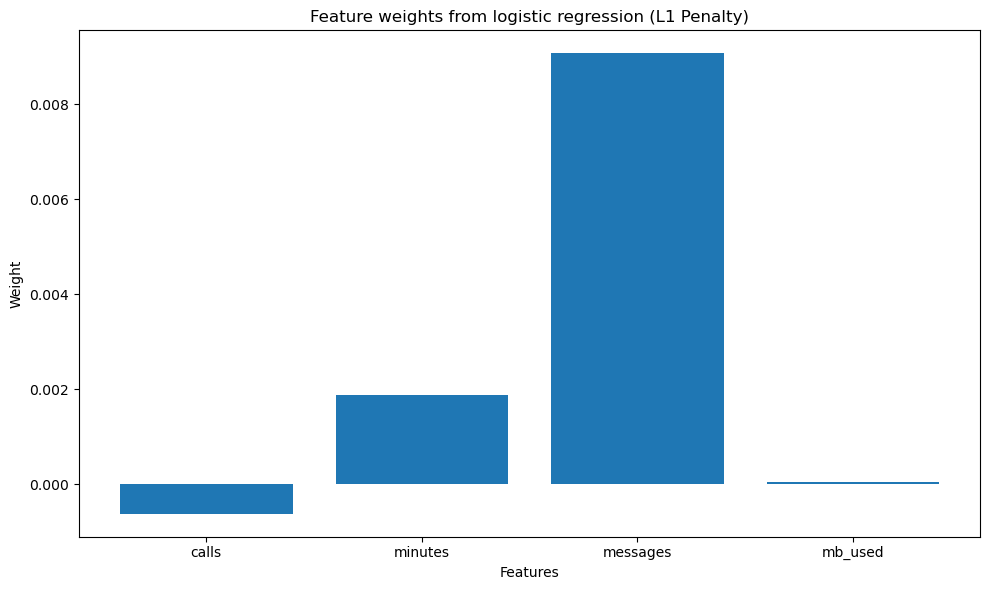

In [ ]:
# show the feature weights
weights = log_reg.coef_[0]

# features names
feature_names = features.columns

# plot of weighting
plt.figure(figsize=(10, 6))
plt.bar(feature_names, weights)
plt.xlabel("Features")
plt.ylabel("Weight")
plt.title("Feature weights from logistic regression (L1 Penalty)")
plt.tight_layout()
plt.show()

thoughts
___
Interesting. although this doesn't tell us exactly how they are used, it does tell us that 'mb_used' was dropped as a meaningful feature. 'messages' is the most important and calls is negative, which means calls have an inverse relationship to plan selection. 

The more calls you make the more likely you are a 'smart' plan, the more messages sent, more likely 'ultra'

In [ ]:
log_test = log_reg.predict(feature_test)
print(accuracy_score(target_test, log_test))

0.7262830482115086


thoughts
___
Test set results were not good enough. This makes sense. We tuned using similiar, but ultimately different data. It should fit the tuned data better. Luckily the accuracy difference was small 75.3% to 72.6% so I don't believe it was dramatically overfit.

Now let's test another model

In [ ]:
# random forest out of the box
rand_forest = RandomForestClassifier(random_state=36)
rand_forest.fit(feature_train, target_train)
print(rand_forest.score(feature_valid, target_valid))

0.8118195956454122


Wonderful! already a better starting place. Time to tune.<br>

Random Forest Classifier is a flow chart to make decisions, we will be focusing on: <br>
n_estimators, which is the number of Trees in the forest. Each Tree is a flowchart<br>
max_depth, which limited the depth or number of decisions the tree makes.<br>
criterion, how are we going to decide on decisions/ splits.
class_weight, our data is 70:30 so we need to pay more attention to the 30 or ultra plan

In [ ]:
best_model = None
best_result = 0

criterion = ['gini', 'entropy']

for est in range(10, 101, 10):
    for depth in range(1, 15):
        for crit in criterion:
            rand_forest = RandomForestClassifier(
                n_estimators=est, max_depth=depth, criterion=crit, class_weight={0: 7/3, 1: 1}, random_state=36)
            rand_forest.fit(feature_train, target_train)

            result = rand_forest.score(feature_valid, target_valid)
            if result > best_result:
                best_result = result
                best_model = rand_forest
                criter = crit


print('best model', best_model)
print('best result', best_result)
print('criterion', criter)

best model RandomForestClassifier(class_weight={0: 2.3333333333333335, 1: 1},
                       criterion='entropy', max_depth=11, n_estimators=30,
                       random_state=36)
best result 0.8258164852255054
criterion entropy


thoughts
___
Slightly better good, not super better<br>
best parameters were adjusting class weight to inverse the actual distribution, at most 11 decisions, with 30 trees, and utilizing the entropy 

In [ ]:
# best model
model = RandomForestClassifier(
    max_depth=11, n_estimators=30, criterion='entropy', class_weight={0: 7/3, 1: 1}, random_state=36)
model.fit(feature_train, target_train)
test_result = model.score(feature_test, target_test)
pred_test = model.predict(feature_test)
print(test_result)

0.7947122861586314


thoughts
___
Close enough to not be overfit!

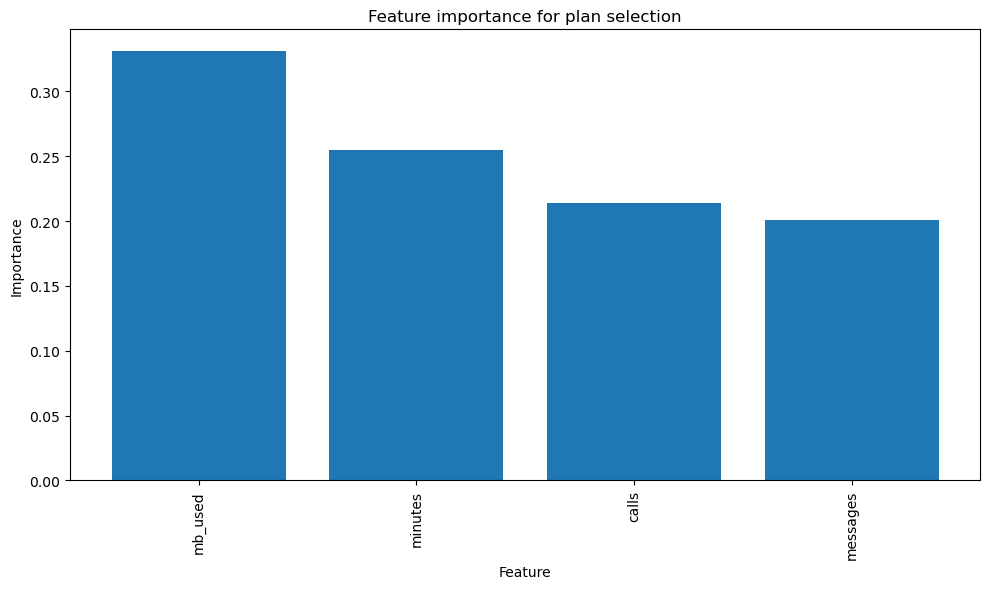

In [ ]:
# feature importance for random forest classifier
feature_importances = rand_forest.feature_importances_

# sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances for plan selection")
plt.bar(range(feature_train.shape[1]), feature_importances[indices])
plt.xticks(range(feature_train.shape[1]), feature_names[indices],
           rotation=90)  # Replace feature_names
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

thoughts
___
Oh important note, these are importances. Meaning mb_used is the most influential in making splits. There is no directionality like the weights had. So mb_used could have a negative relationship, or a positive one. We only know the model used the value of mb_used more in making decisions.

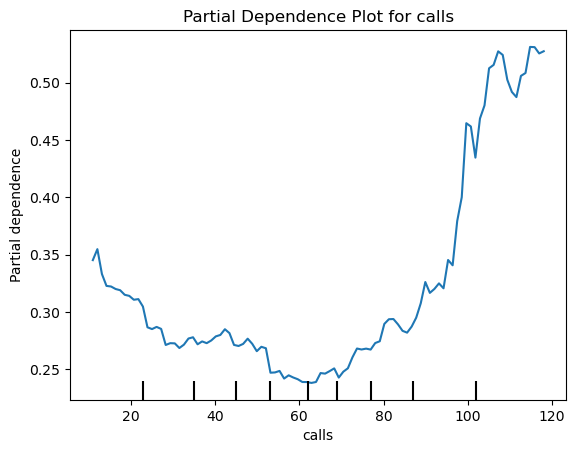

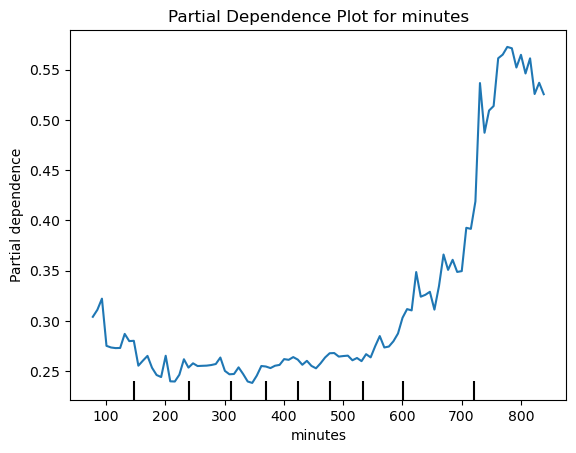

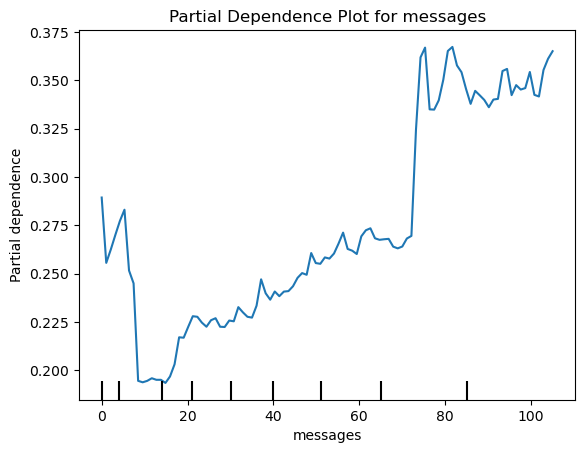

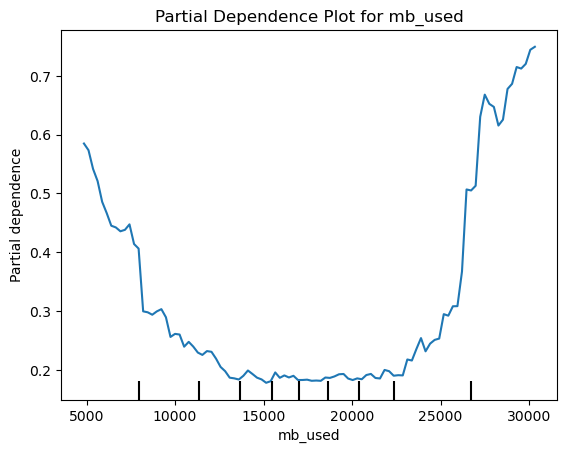

In [ ]:
# partial dependences for our features
for feature in feature_names:
    PartialDependenceDisplay.from_estimator(
        rand_forest, feature_train, features=[feature])
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.show()

thoughts
___
A partial dependence chart shows how, as a feature's value changes, the model's prediction changes, when you keep other features at a constant value.  In this case, the partial dependence plot will show the model's tendency to predict the "Ultra" plan changes as the feature value varies. The y axis is probablity of selecting ultra.

Phone usage is likely correlated though, so these plots are not perfect.

______
Conclusion
___
Random Forest Classifier gave us the best accuracy score on the test set. Mb_used was the most influential feature. This makes sense. Customers can look at personal usage data and decide what plan fits them best. Overage charges are lame.